### Data extraction
Extract data from MIMIC-III

In [1]:
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cufflinks

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
# Import pandas 
import pandas as pd 

start = time.time()
# reading csv file 
admissions_df = pd.read_csv("../../datasets/mmc-3/ADMISSIONS.csv")
noteevents_df = pd.read_csv("../../datasets/mmc-3/NOTEEVENTS.csv") 
end = time.time()
print(end - start)


/home/evan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



35.027766704559326


In [3]:
start = time.time()
# Left join of two dataframes
note_admiss_df_left = noteevents_df.merge(admissions_df, on='HADM_ID', how='left', indicator=True)
end = time.time()
print(end - start)

4.46708345413208


In [4]:
note_admiss_df_left[['DIAGNOSIS', 'SUBJECT_ID_x', 'SUBJECT_ID_y','DESCRIPTION', 'CATEGORY']]

,DIAGNOSIS,SUBJECT_ID_x,SUBJECT_ID_y,DESCRIPTION,CATEGORY
0,RT LOWER LOBE PNEUMONIA,22532,22532.0,Report,Discharge summary
1,CHRONIC OBSTRUCTIVE PULMONARY DISEASE,13702,13702.0,Report,Discharge summary
2,TRACHEALBRONCHEAL MALACEA/SDA,13702,13702.0,Report,Discharge summary
3,ASTHMA;COPD EXACERBATION,13702,13702.0,Report,Discharge summary
4,S/P FALL;TELEMETRY,26880,26880.0,Report,Discharge summary
...,...,...,...,...,...
2083175,NEWBORN,31097,31097.0,Report,Nursing/other
2083176,NEWBORN,31097,31097.0,Report,Nursing/other
2083177,NEWBORN,31097,31097.0,Report,Nursing/other
2083178,NEWBORN,31097,31097.0,Report,Nursing/other


In [5]:
pneumonia_df = note_admiss_df_left.loc[note_admiss_df_left["DIAGNOSIS"] == 'PNEUMONIA', ['ROW_ID_x', 'SUBJECT_ID_x', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA']]

In [6]:
#pneumonia_no_disch_df = pneumonia_df.loc[pneumonia_df["CATEGORY"] != 'Discharge summary', ['ROW_ID_x', 'SUBJECT_ID_x', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA']]
pneumonia_no_disch_df = pneumonia_df.loc[pneumonia_df["CATEGORY"] != 'Discharge summary', ['ROW_ID_x','SUBJECT_ID_x','CHARTDATE','STORETIME','CATEGORY','DESCRIPTION','TEXT', 'DEATHTIME']]

In [7]:
pneumonia_alive_no_disch = pneumonia_no_disch_df[pneumonia_no_disch_df.DEATHTIME.isnull()]
pneumonia_dead_no_disch = pneumonia_no_disch_df[pneumonia_no_disch_df.DEATHTIME.notnull()]

In [8]:
pneumonia_dead_no_disch.shape

(11895, 8)

In [9]:
pneumonia_alive_no_disch.shape

(46134, 8)

In [10]:
pneumonia_alive_no_disch = pneumonia_alive_no_disch.sort_values(by=['SUBJECT_ID_x','CHARTDATE', 'ROW_ID_x'])
pneumonia_dead_no_disch = pneumonia_dead_no_disch.sort_values(by=['SUBJECT_ID_x','CHARTDATE', 'ROW_ID_x'])

In [11]:
# Number of patients
pneumonia_dead_no_disch['SUBJECT_ID_x'].nunique()

252

In [12]:
# Number of patients
pneumonia_alive_no_disch['SUBJECT_ID_x'].nunique()

1167

In [13]:
# import text handling tool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from collections import Counter

import sys
import re
import csv
import os.path

# define constants
# RESULT_HEADER = "WORD, FREQUENCY\n"
MIN_SEQ_LEN = 4
USE_1_N_SEQ = 2


# words that do not have meaning (can be modified later)
USELESS_WORDS = ["a", "the", "he", "she", ",", ".", "?", "!", ":", ";", "+", "*", "**"\
                 "your", "you"]

# count up the frequency of every word in every disease file
stemmer = PorterStemmer()
# create set of words to ignore in text
stop_words = set(stopwords.words('english'))

for word in USELESS_WORDS:
    stop_words.add(word)

In [14]:

#----------
def count_notes_per_patient(disease_df):
    patient_id_to_num_notes = {}
    patient_id = -1
    note_counter = 0
            
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        patient_id_check = int(row['SUBJECT_ID_x'])
                
        if not patient_id == patient_id_check:
            patient_id_to_num_notes[patient_id] = note_counter
            note_counter = 1
        else:
            note_counter += 1
                    
        patient_id = patient_id_check
                
    patient_id_to_num_notes[patient_id] = note_counter
    del patient_id_to_num_notes[-1]
    return patient_id_to_num_notes

patient_id_to_num_notes = {}
patient_id_to_num_notes['pneumonia_dead'] = count_notes_per_patient(pneumonia_dead_no_disch)
patient_id_to_num_notes['pneumonia_alive'] = count_notes_per_patient(pneumonia_alive_no_disch)

100%|██████████| 46134/46134 [00:04<00:00, 9415.90it/s] 


In [15]:
patient_id_to_num_notes

{'pneumonia_dead': {111: 12,
  346: 25,
  404: 3,
  546: 6,
  618: 16,
  705: 15,
  726: 48,
  1039: 55,
  1556: 37,
  1872: 3,
  1944: 56,
  2286: 69,
  2990: 166,
  3055: 29,
  3099: 13,
  3201: 8,
  3526: 7,
  3773: 6,
  3881: 20,
  4122: 51,
  4754: 101,
  4811: 21,
  5476: 1,
  5494: 22,
  5774: 104,
  5786: 152,
  5913: 1,
  6133: 68,
  6735: 13,
  6745: 13,
  6973: 36,
  6981: 8,
  7277: 66,
  7310: 8,
  7924: 9,
  7977: 9,
  9908: 11,
  9984: 15,
  10302: 100,
  10510: 86,
  10545: 10,
  10642: 10,
  11049: 14,
  11209: 9,
  11395: 41,
  12530: 24,
  12849: 50,
  13098: 46,
  13566: 23,
  14125: 9,
  14514: 96,
  14965: 25,
  15159: 15,
  15251: 11,
  15396: 17,
  15566: 37,
  15853: 45,
  16275: 17,
  16344: 27,
  16622: 51,
  16684: 29,
  17122: 16,
  17354: 5,
  17802: 64,
  17983: 65,
  18094: 23,
  18736: 35,
  18768: 46,
  18848: 205,
  18971: 26,
  19243: 25,
  19323: 6,
  19390: 21,
  19463: 20,
  19535: 59,
  19754: 13,
  19827: 22,
  19833: 58,
  19872: 10,
  20006: 8

In [16]:
print(len(patient_id_to_num_notes['pneumonia_dead']))
print(len(patient_id_to_num_notes['pneumonia_alive']))

252
1167


In [17]:
pneumonia_dead_no_disch.loc[pneumonia_dead_no_disch["SUBJECT_ID_x"] == 111, ['ROW_ID_x','SUBJECT_ID_x','DESCRIPTION','TEXT', 'DEATHTIME']]

,ROW_ID_x,SUBJECT_ID_x,DESCRIPTION,TEXT,DEATHTIME
70391,70124,111,Report,PATIENT/TEST INFORMATION:\nIndication: s/p PEA...,2144-07-01 14:55:00
142529,151749,111,Report,Compared to the previous tracing QRS voltage i...,2144-07-01 14:55:00
142097,151750,111,Report,"Normal sinus rhythm, rate 80. Biatrial abnorm...",2144-07-01 14:55:00
142303,151751,111,Report,Normal sinus rhythm. Q waves in leads V1-V2 c...,2144-07-01 14:55:00
380576,375732,111,Physician Resident Admission Note,Chief Complaint: respiratory distress\n HPI...,2144-07-01 14:55:00
380109,375744,111,ICU Event Note,Clinician: Nurse\n Pt admitted from the ED ...,2144-07-01 14:55:00
379907,375749,111,Physician Resident/Attending Admission Note - ...,Chief Complaint: respiratory distress\n HPI...,2144-07-01 14:55:00
379806,375753,111,Social Work Admission Note,Social Work Initial Note:\n Family Informati...,2144-07-01 14:55:00
379909,375760,111,ICU Event Note,TITLE:\n Clinician: Resident\n Patient ex...,2144-07-01 14:55:00
1066971,1079317,111,CHEST (PORTABLE AP),[**2144-7-1**] 2:43 AM\n CHEST (PORTABLE AP) ...,2144-07-01 14:55:00


In [18]:
def count_words_per_patient(disease_df, patient_id_to_num_notes):
    note_appearance_counter = {}
    number_of_patients = 0 # number of patients
    note_counter = 0

# -----------
    patient_id = -1
    word_set = set()
    note_event_counter = 0

    # Iterate through each note
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):

        
        patient_id_check = int(row['SUBJECT_ID_x'])
    
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check:
            number_of_patients += 1
            note_event_counter = 0
        
            for word in word_set:
                if word in note_appearance_counter:
                    note_appearance_counter[word] += 1
                else:
                    note_appearance_counter[word] = 1

        
            # reset word_set
            word_set = set()
        
        # update patient id
        patient_id = patient_id_check

            
        if patient_id_to_num_notes[patient_id_check] <= MIN_SEQ_LEN:
            continue
            
        if note_event_counter < patient_id_to_num_notes[patient_id] // USE_1_N_SEQ:
            note_event_counter += 1
            continue
                
        note_counter += 1
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        tokenized_note = word_tokenize(note)
        
        
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())
            if not stemmed_word in stop_words:
                word_set.add(stemmed_word)
    
    print(str(note_counter) + " note events")
    print("finished counting frequent words for patients!")
#     return note_counter, note_appearance_counter
    return number_of_patients, note_appearance_counter

# variable dictionaries
number_of_notes = {}
note_appearance_counter = {}

number_of_notes['pneumonia_dead'], note_appearance_counter['pneumonia_dead'] = count_words_per_patient(pneumonia_dead_no_disch, patient_id_to_num_notes['pneumonia_dead'])
number_of_notes['pneumonia_alive'], note_appearance_counter['pneumonia_alive'] = count_words_per_patient(pneumonia_alive_no_disch, patient_id_to_num_notes['pneumonia_alive'])

  0%|          | 11/46134 [00:00<07:10, 107.03it/s]

5989 note events
finished counting frequent words for patients!


100%|██████████| 46134/46134 [02:49<00:00, 271.98it/s]

23172 note events
finished counting frequent words for patients!


In [19]:
number_of_notes

{'pneumonia_dead': 252, 'pneumonia_alive': 1167}

In [20]:
print(note_appearance_counter)

{'pneumonia_dead': {'wa': 210, 'notabl': 38, 'levofloxacin': 40, 'receiv': 151, 'electrolyt': 43, 'edema': 182, 'niec': 13, 'bicarb': 28, 'inr': 88, 'non': 170, 'full': 124, 'cvl': 42, 'hilar': 36, 'legal': 10, 'manag': 90, 'baselin': 86, 'physic': 72, 'past': 77, 'lactic': 54, 'glycem': 62, 'bpm': 102, 'son': 89, 'show': 131, 'answer': 59, 'apic': 43, 'mix': 30, 'empir': 36, 'approxim': 72, 'suffer': 13, 'clinic': 117, 'sinc': 186, 'intact': 103, 'insert': 61, 'azotemia': 6, 'situat': 29, 'pco': 36, 'plt': 82, 'rub': 32, 'elig': 3, 'ipratropium': 6, 'law': 18, 'fix': 29, 'work': 87, 'hr': 189, 'stay': 55, 'bed': 103, 'volum': 119, 'cage': 1, 'want': 92, 'c': 177, 'sodium': 63, 'exceed': 3, 'section': 56, 'would': 127, 'impress': 176, 'went': 50, 'peripher': 97, 'ventilatori': 63, 'leukocytosi': 37, 'appropri': 101, 'fir': 2, 'simvastatin': 4, 'anur': 28, 'cultur': 100, 'amylas': 17, 'though': 89, 'ptx': 24, 'phenylephrin': 16, 'presum': 40, 'nc': 62, 'cool': 67, 'took': 27, 'recruit':

In [21]:
# # get hyper-paramters n_fold and threshold from user input
n_fold = float(3)
threshold = float(0.01)

frequent_word_lists = {}
factor = {}

In [22]:
"""function description:
for each disease in note_appearance_counter
    1. checks whether a word in disease file is frequent(frequency standard as defined by factor, n_fold, and threshold)
    2. adds to frequent_word_list
"""

# def find_frequent_word(note_appearance_counter, frequent_word_lists, number_of_notes, factor, n_fold, threshold):

# calculate normalizing factor for each disease
note_sum = 0

# Count from two labels
for disease in number_of_notes:
    note_sum += float(number_of_notes[disease])
    
for disease in number_of_notes:
    factor[disease] = number_of_notes[disease] / note_sum

# determine frequent word for each disease file
for disease in note_appearance_counter:
    frequent_word_lists[disease] = []

    print(disease + " has " + str(len(note_appearance_counter[disease])) + " unique words!")

    for word in note_appearance_counter[disease]:
        
        freq_check = True
        for check_disease in note_appearance_counter:
            
            if not disease == check_disease:
                if word in note_appearance_counter[check_disease]:
                    if not (note_appearance_counter[disease][word] / note_appearance_counter[check_disease][word] / factor[disease] * factor[check_disease] > n_fold \
                        and note_appearance_counter[disease][word] > (number_of_notes[disease] * threshold)):

                        freq_check = False
                        break

                else:
                    if not (note_appearance_counter[disease][word] > n_fold and note_appearance_counter[disease][word] > (number_of_notes[disease] * threshold)):
                        freq_check = False
                        break
        if freq_check:
            frequent_word_lists[disease].append((word))
            # Create a tuple of word and its count
#             frequent_word_lists[disease].append((word, note_appearance_counter[disease][word]))

        

print("finished making frequent words list for " + disease)

pneumonia_dead has 11678 unique words!
pneumonia_alive has 22572 unique words!
finished making frequent words list for pneumonia_alive


In [23]:
print(note_sum)
print(factor)

# number of notes
# 58029.0
# {'pneumonia_dead': 0.2049837150390322, 'pneumonia_alive': 0.7950162849609678}

1419.0
{'pneumonia_dead': 0.17758985200845667, 'pneumonia_alive': 0.8224101479915433}


In [24]:
print(len(frequent_word_lists['pneumonia_dead']))
print(len(frequent_word_lists['pneumonia_alive']))


# n_fold = float(3) threshold = float(0.01)
# 454
# 329

# n_fold = float(2) threshold = float(0.01)
# 914
# 600

# n_fold = float(1) threshold = float(0.01)
# 3320
# 2196

454
329


In [25]:
print(frequent_word_lists)

{'pneumonia_dead': ['suffer', 'azotemia', 'elig', 'anur', 'phenylephrin', 'recruit', 'hypercapn', 'clergi', 'unrespons', 'dic', 'pea', 'norepinephrin', 'arrest', 'funer', 'pcv', 'vasopressin', 'park', 'mottl', 'expir', 'refractori', 'hypercapnia', 'cremat', 'acidem', 'profound', 'arrang', 'death', 'cpr', 'hypothermia', 'autopeep', 'paralyt', 'bicarbon', 'clinician', 'dnr', 'cmo', 'virtual', 'slough', 'pinpoint', 'dni', 'dk', 'gum', 'nonpurpos', 'nacl', 'sluggish', 'lubric', 'oder', 'float', 'clariti', 'wish', 'levoph', 'mso', 'antb', 'option', 'hypotent', 'bow', 'viabl', 'respon', 'dd', 'remin', 'grim', 'purpl', 'priest', 'gather', 'institut', 'pronounc', 'peerla', 'prognosi', 'suport', 'dead', 'bye', 'mortem', 'agreement', 'centimet', 'aprv', 'mad', 'life', 'asystol', 'depth', 'synch', 'acv', 'througout', 'peac', 'duski', 'surviv', 'nrbm', 'sync', 'chaplain', 'mgx', 'moniotr', 'hover', 'cathol', 'ppn', 'seriou', 'vasopressor', 'jerk', 'pulseless', 'pfr', 'crrt', 'suppport', 'rusti', '

### 2. Co-occurrence generation
FP-growth

In [26]:
FREQUENT_WORD_LIST = frequent_word_lists['pneumonia_dead'] + frequent_word_lists['pneumonia_alive']
print(len(FREQUENT_WORD_LIST))
print(len(set(FREQUENT_WORD_LIST)))

783
783


In [27]:
"""function description:
generates frequent word set for the disease
"""
word_dict = {}
word_id = 1
stemmer = PorterStemmer()


for word in FREQUENT_WORD_LIST:
    if not word == "WORD":
        word_dict[stemmer.stem(word.strip())] = word_id
        word_id += 1
             
print(f"\nword dictionary created! Length: {len(word_dict)}\n")
print(word_dict)



word dictionary created! Length: 783

{'suffer': 1, 'azotemia': 2, 'elig': 3, 'anur': 4, 'phenylephrin': 5, 'recruit': 6, 'hypercapn': 7, 'clergi': 8, 'unrespon': 9, 'dic': 10, 'pea': 11, 'norepinephrin': 12, 'arrest': 13, 'funer': 14, 'pcv': 15, 'vasopressin': 16, 'park': 17, 'mottl': 18, 'expir': 19, 'refractori': 20, 'hypercapnia': 21, 'cremat': 22, 'acidem': 23, 'profound': 24, 'arrang': 25, 'death': 26, 'cpr': 27, 'hypothermia': 28, 'autopeep': 29, 'paralyt': 30, 'bicarbon': 31, 'clinician': 32, 'dnr': 33, 'cmo': 34, 'virtual': 35, 'slough': 36, 'pinpoint': 37, 'dni': 38, 'dk': 39, 'gum': 40, 'nonpurpo': 41, 'nacl': 42, 'sluggish': 43, 'lubric': 44, 'oder': 45, 'float': 46, 'clariti': 47, 'wish': 48, 'levoph': 49, 'mso': 50, 'antb': 51, 'option': 52, 'hypot': 53, 'bow': 54, 'viabl': 55, 'respon': 56, 'dd': 57, 'remin': 58, 'grim': 59, 'purpl': 60, 'priest': 61, 'gather': 62, 'institut': 63, 'pronounc': 64, 'peerla': 65, 'prognosi': 66, 'suport': 67, 'dead': 68, 'bye': 69, 'mortem

### Implementetion with python for FP_growth

### Count co-occurrences per patient

In [28]:
import os
import operator
from pathlib import Path
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import math

# ----
def fp_growth_input_per_patient_python(disease_df, word_dict, min_support):
    
    # For dataframe
    patient_cooc_dict = {}
    patient_node_dict = {}
    patient_note_cnt = {}
    
    # --------------    
    patient_id = -1
    note_cnt = 0
    patient_note_list = []
    
    # read line in from file (each line is one note)
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        
        # only regard certain type of notes
        patient_id_check = int(row['SUBJECT_ID_x'])
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        patient_word_set = set()
    
#         print(f"patient_id_check: {patient_id_check}, patient_id: {patient_id}")
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check and not patient_id == -1:
            te = TransactionEncoder()
            te_ary = te.fit(patient_note_list).transform(patient_note_list)
            df = pd.DataFrame(te_ary, columns=te.columns_)
            df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
            cooc_tmp = []
            cooc_minsup_tmp = []
            node_minsup_tmp = []
            cooc_node_idx_tmp = []
            
            for index, row in df_itemsets.iterrows():
                if len(row['itemsets']) == 1:
                    word = list(row['itemsets'])[0]
                    min_sup = row['support']

                    node_minsup_tmp.append(len(patient_note_list) * row['support'])
                    cooc_node_idx_tmp.append(word)
                    
                if len(row['itemsets']) == 2:
                    cooc_ = sorted(list(row['itemsets']))
                    cooc_tmp.append(cooc_)
                    cooc_minsup_tmp.append(len(patient_note_list) * row['support'])
            
            cooc_dict = {}

            for num, i in enumerate(cooc_tmp):
                if tuple(i) not in cooc_dict:
                    cooc_dict[tuple(i)] = cooc_minsup_tmp[num]

            # dictionary = dict(zip(keys, values))
            node_dict = {}
            for num, i in enumerate(cooc_node_idx_tmp):
                if i not in node_dict:
                    node_dict[i] = node_minsup_tmp[num]
                    
            # Update glob lists
            if patient_id not in patient_cooc_dict:
                patient_cooc_dict[patient_id] = cooc_dict
                patient_node_dict[patient_id] = node_dict
                patient_note_cnt[patient_id] = note_cnt
            else:
                print(f"patient_id: {patient_id} is already in the dictionary!")
            
            
            # Reset local lists
            patient_note_list = []
            note_cnt = 0
                    
        # update patient id
        patient_id = patient_id_check
        tokenized_note = word_tokenize(note)
        note_cnt += 1

        # loop through each word in note to count word belonging to each disease
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())       
            if stemmed_word in word_dict:
                    patient_word_set.add(stemmed_word)

        templst = []
        for word in patient_word_set:
            templst.append(word)

        if templst:
            patient_note_list.append(templst)
    
    # Last patient info
    te = TransactionEncoder()
    te_ary = te.fit(patient_note_list).transform(patient_note_list)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
    cooc_tmp = []
    cooc_minsup_tmp = []
    #-----
    node_minsup_tmp = []
    cooc_node_idx_tmp = []
            
    for index, row in df_itemsets.iterrows():
        if len(row['itemsets']) == 1:
            word = list(row['itemsets'])[0]
            node_minsup_tmp.append(len(patient_note_list) * row['support'])
            cooc_node_idx_tmp.append(word)

        if len(row['itemsets']) == 2:
            cooc_ = sorted(list(row['itemsets']))
            cooc_tmp.append(cooc_)
            cooc_minsup_tmp.append(len(patient_note_list) * row['support'])
    
                    
    cooc_dict = {}

    for num, i in enumerate(cooc_tmp):
        if tuple(i) not in cooc_dict:
            cooc_dict[tuple(i)] = cooc_minsup_tmp[num]

    # dictionary = dict(zip(keys, values))
    node_dict = {}
    for num, i in enumerate(cooc_node_idx_tmp):
        if i not in node_dict:
            node_dict[i] = node_minsup_tmp[num]

    # Update glob lists
    if patient_id not in patient_cooc_dict:
        patient_cooc_dict[patient_id] = cooc_dict
        patient_node_dict[patient_id] = node_dict
        patient_note_cnt[patient_id] = note_cnt
    else:
        print(f"patient_id: {patient_id} is already in the dictionary!")

    return patient_node_dict, patient_cooc_dict, patient_note_cnt

patient_node_0, patient_cooc_0, patient_note_num_0 = fp_growth_input_per_patient_python(pneumonia_dead_no_disch, word_dict, 0.1)
patient_node_1, patient_cooc_1, patient_note_num_1 = fp_growth_input_per_patient_python(pneumonia_alive_no_disch, word_dict, 0.1)

100%|██████████| 46134/46134 [34:45<00:00, 22.12it/s]   


In [29]:
print(patient_node_1)

{68: {'dizzi': 1.0, 'declin': 1.0, 'breakfast': 1.0, 'chip': 1.0, 'lpm': 1.0, 'thirst': 1.0, 'aaox': 1.0, 'fee': 1.0, 'fluor': 1.0, 'ambul': 4.0, 'commod': 4.0, 'cracker': 1.0, 'hunger': 1.0, 'chair': 2.0, 'gait': 2.0, 'vtach': 1.0, 'unsteadi': 1.0, 'oob': 2.0, 'pcv': 1.0, 'ambien': 1.0, 'pleasant': 1.0}, 85: {'lat': 1.0}, 94: {'lift': 11.0, 'incis': 6.0, 'dopamin': 11.0, 'oob': 7.000000000000001}, 165: {'habitu': 1.0}, 211: {'dopamin': 3.0, 'aox': 3.0, 'chair': 2.0, 'lpm': 2.0, 'levoph': 3.0, 'lat': 2.0}, 224: {'lat': 1.0, 'rigor': 1.0, 'platelet': 1.0, 'commod': 1.0, 'awhil': 1.0, 'fax': 1.0, 'bank': 1.0, 'pleasant': 1.0, 'chair': 1.0}, 231: {"tf'ing": 3.0, 'oob': 3.0, 'msicu': 3.0}, 283: {'recruit': 10.0, 'criticar': 10.0}, 357: {'unasyn': 4.0, 'intent': 2.0, 'dz': 2.0, 'ctx': 2.0, 'thiamin': 1.0, 'moan': 4.0, 'wallet': 1.0, 'signatur': 1.0, 'money': 1.0, 'jewelri': 1.0, 'cloth': 1.0, 'cash': 1.0, 'distort': 2.0}, 368: {'pleasant': 3.0, 'dnr': 3.0, 'epigastr': 2.0, 'hhn': 3.0, 'lpm'

In [30]:
print(patient_cooc_1)

{68: {('breakfast', 'declin'): 1.0, ('breakfast', 'chip'): 1.0, ('chip', 'declin'): 1.0, ('chip', 'lpm'): 1.0, ('breakfast', 'lpm'): 1.0, ('declin', 'lpm'): 1.0, ('lpm', 'thirst'): 1.0, ('chip', 'thirst'): 1.0, ('breakfast', 'thirst'): 1.0, ('declin', 'thirst'): 1.0, ('aaox', 'thirst'): 1.0, ('aaox', 'lpm'): 1.0, ('aaox', 'chip'): 1.0, ('aaox', 'breakfast'): 1.0, ('aaox', 'declin'): 1.0, ('fee', 'fluor'): 1.0, ('ambul', 'commod'): 3.0, ('commod', 'cracker'): 1.0, ('ambul', 'cracker'): 1.0, ('cracker', 'hunger'): 1.0, ('commod', 'hunger'): 1.0, ('ambul', 'hunger'): 1.0, ('chair', 'oob'): 1.0, ('chair', 'commod'): 1.0, ('ambul', 'chair'): 1.0, ('chair', 'gait'): 1.0, ('ambul', 'gait'): 1.0, ('gait', 'vtach'): 1.0, ('ambul', 'vtach'): 1.0, ('unsteadi', 'vtach'): 1.0, ('gait', 'unsteadi'): 1.0, ('ambul', 'unsteadi'): 1.0, ('commod', 'oob'): 2.0, ('ambul', 'oob'): 2.0, ('oob', 'pcv'): 1.0, ('commod', 'pcv'): 1.0, ('ambul', 'pcv'): 1.0, ('ambien', 'commod'): 1.0, ('ambien', 'pleasant'): 1.0,

In [31]:
patient_note_num_0

{111: 12,
 346: 25,
 404: 3,
 546: 6,
 618: 16,
 705: 15,
 726: 48,
 1039: 55,
 1556: 37,
 1872: 3,
 1944: 56,
 2286: 69,
 2990: 166,
 3055: 29,
 3099: 13,
 3201: 8,
 3526: 7,
 3773: 6,
 3881: 20,
 4122: 51,
 4754: 101,
 4811: 21,
 5476: 1,
 5494: 22,
 5774: 104,
 5786: 152,
 5913: 1,
 6133: 68,
 6735: 13,
 6745: 13,
 6973: 36,
 6981: 8,
 7277: 66,
 7310: 8,
 7924: 9,
 7977: 9,
 9908: 11,
 9984: 15,
 10302: 100,
 10510: 86,
 10545: 10,
 10642: 10,
 11049: 14,
 11209: 9,
 11395: 41,
 12530: 24,
 12849: 50,
 13098: 46,
 13566: 23,
 14125: 9,
 14514: 96,
 14965: 25,
 15159: 15,
 15251: 11,
 15396: 17,
 15566: 37,
 15853: 45,
 16275: 17,
 16344: 27,
 16622: 51,
 16684: 29,
 17122: 16,
 17354: 5,
 17802: 64,
 17983: 65,
 18094: 23,
 18736: 35,
 18768: 46,
 18848: 205,
 18971: 26,
 19243: 25,
 19323: 6,
 19390: 21,
 19463: 20,
 19535: 59,
 19754: 13,
 19827: 22,
 19833: 58,
 19872: 10,
 20006: 8,
 20023: 9,
 20190: 6,
 21046: 101,
 21094: 36,
 21427: 10,
 21502: 102,
 21580: 52,
 21676: 12,


#### Create set of patient co-occurrences from two groups

In [32]:
# Create a set of all unique co-occurrences from both group
patient_cooc_set = set()
patient_cooc_0_dict = {}
patient_cooc_1_dict = {}

for k, v in patient_cooc_0.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_0_dict:
            patient_cooc_0_dict[item] = v[item]
        else:
            patient_cooc_0_dict[item] = patient_cooc_0_dict[item] + v[item]
            
    
for k, v in patient_cooc_1.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_1_dict:
            patient_cooc_1_dict[item] = v[item]
        else:
            patient_cooc_1_dict[item] = patient_cooc_1_dict[item] + v[item]

In [33]:
print(len(patient_cooc_set))
print(len(patient_cooc_0_dict))
print(len(patient_cooc_1_dict))

11183
3508
8465


In [34]:
# count log-odds score

# reverse
# --------------- co-occurrences --------------->

        
# Get the set of coocurrencies from two groups
# Count log_odd_score

patient_cooc_odd_scores = {}
for set_item in patient_cooc_set:
    if set_item in patient_cooc_0_dict and set_item in patient_cooc_1_dict: 
        d_prob = patient_cooc_0_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        a_prob = patient_cooc_1_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
# --------------- co-occurrences ---------------<

In [35]:
patient_cooc_odd_scores

{('ambien', 'epidur'): 6.90875477931522,
 ('aaox', 'lpm'): 6.90875477931522,
 ('neosynephrin', 'uri'): 6.90875477931522,
 ('anur', 'dopamin'): -6.90875477931522,
 ('gentamycin', 'multisystem'): -6.90875477931522,
 ('mellitu', 'schizophrenia'): 6.90875477931522,
 ('hospic', 'osa'): -6.90875477931522,
 ('hunger', 'levoph'): -6.90875477931522,
 ('morbid', 'romi'): 6.90875477931522,
 ('calvarium', 'occipit'): 6.90875477931522,
 ('asthma', 'vallecula'): 6.90875477931522,
 ('lotion', 'schizophrenia'): 6.90875477931522,
 ('oncologist', 'retic'): 6.90875477931522,
 ('appi', 'arrest'): 6.90875477931522,
 ('bottl', 'seroquel'): 6.90875477931522,
 ('cvvh', 'pitressin'): -6.90875477931522,
 ('trazodon', 'vasopressin'): -6.90875477931522,
 ('contd', 'wallet'): 6.90875477931522,
 ('epigastr', 'mrg'): 6.90875477931522,
 ('ambien', 'modifi'): 6.90875477931522,
 ('cpr', 'modifi'): 6.90875477931522,
 ('artifici', 'life'): -6.90875477931522,
 ('nahco', 'pitressin'): -6.90875477931522,
 ('ambien', 'levoph

### Train mode

#### Method 2. Each patient graph => [model training]

In [36]:
# Dictionaries to use
 # struct: {word: word2vec[128, numpy.array]}
patient_cooc_odd_scores # struct: {cooc_tuple: log_odds_score}
print()

In [37]:
patient_cooc_odd_scores 

{('ambien', 'epidur'): 6.90875477931522,
 ('aaox', 'lpm'): 6.90875477931522,
 ('neosynephrin', 'uri'): 6.90875477931522,
 ('anur', 'dopamin'): -6.90875477931522,
 ('gentamycin', 'multisystem'): -6.90875477931522,
 ('mellitu', 'schizophrenia'): 6.90875477931522,
 ('hospic', 'osa'): -6.90875477931522,
 ('hunger', 'levoph'): -6.90875477931522,
 ('morbid', 'romi'): 6.90875477931522,
 ('calvarium', 'occipit'): 6.90875477931522,
 ('asthma', 'vallecula'): 6.90875477931522,
 ('lotion', 'schizophrenia'): 6.90875477931522,
 ('oncologist', 'retic'): 6.90875477931522,
 ('appi', 'arrest'): 6.90875477931522,
 ('bottl', 'seroquel'): 6.90875477931522,
 ('cvvh', 'pitressin'): -6.90875477931522,
 ('trazodon', 'vasopressin'): -6.90875477931522,
 ('contd', 'wallet'): 6.90875477931522,
 ('epigastr', 'mrg'): 6.90875477931522,
 ('ambien', 'modifi'): 6.90875477931522,
 ('cpr', 'modifi'): 6.90875477931522,
 ('artifici', 'life'): -6.90875477931522,
 ('nahco', 'pitressin'): -6.90875477931522,
 ('ambien', 'levoph

In [38]:
# Data normalization
import numpy
def data_norm(cooc_odd_scores):

    def norm_arr(array):
        arr = numpy.array(list(array))
        start = 0
        end = 1
        width = end - start
        res = (arr - arr.min())/(arr.max() - arr.min()) * width + start
        return res.tolist()

    cooc_keys, cooc_values = zip(*cooc_odd_scores.items())
    new_cooc_odd_scores = dict(zip(cooc_keys, norm_arr(cooc_values)))

    return new_cooc_odd_scores

new_patient_cooc_odd_scores = data_norm(patient_cooc_odd_scores)

In [39]:
new_patient_cooc_odd_scores

{('ambien', 'epidur'): 1.0,
 ('aaox', 'lpm'): 1.0,
 ('neosynephrin', 'uri'): 1.0,
 ('anur', 'dopamin'): 0.0,
 ('gentamycin', 'multisystem'): 0.0,
 ('mellitu', 'schizophrenia'): 1.0,
 ('hospic', 'osa'): 0.0,
 ('hunger', 'levoph'): 0.0,
 ('morbid', 'romi'): 1.0,
 ('calvarium', 'occipit'): 1.0,
 ('asthma', 'vallecula'): 1.0,
 ('lotion', 'schizophrenia'): 1.0,
 ('oncologist', 'retic'): 1.0,
 ('appi', 'arrest'): 1.0,
 ('bottl', 'seroquel'): 1.0,
 ('cvvh', 'pitressin'): 0.0,
 ('trazodon', 'vasopressin'): 0.0,
 ('contd', 'wallet'): 1.0,
 ('epigastr', 'mrg'): 1.0,
 ('ambien', 'modifi'): 1.0,
 ('cpr', 'modifi'): 1.0,
 ('artifici', 'life'): 0.0,
 ('nahco', 'pitressin'): 0.0,
 ('ambien', 'levoph'): 1.0,
 ('captopril', 'declin'): 0.0,
 ('quinolon', 'sweat'): 1.0,
 ('bromid', 'opiat'): 1.0,
 ('dic', 'pneumonectomi'): 0.0,
 ('bair', 'moan'): 0.0,
 ('epigastr', 'zoloft'): 1.0,
 ('cvvhd', 'dni'): 1.0,
 ('hive', 'signatur'): 1.0,
 ('fatti', 'hive'): 1.0,
 ('asthma', 'montitor'): 0.0,
 ('dead', 'rehabil

In [40]:
# patient_dead_cooc_df
print(patient_cooc_0)

{111: {('arrest', 'pea'): 5.0, ('pea', 'vasopressin'): 4.0, ('arrest', 'vasopressin'): 4.0, ('cpr', 'vasopressin'): 4.0, ('cpr', 'pea'): 4.0, ('arrest', 'cpr'): 4.0, ('azotemia', 'cpr'): 2.0, ('azotemia', 'vasopressin'): 2.0, ('azotemia', 'pea'): 2.0, ('arrest', 'azotemia'): 2.0, ('azotemia', 'profound'): 1.0, ('azotemia', 'dic'): 2.0, ('cpr', 'dic'): 2.0, ('dic', 'vasopressin'): 2.0, ('dic', 'pea'): 2.0, ('arrest', 'dic'): 2.0, ('dic', 'profound'): 1.0, ('dic', 'hypercapnia'): 2.0, ('azotemia', 'hypercapnia'): 2.0, ('cpr', 'hypercapnia'): 2.0, ('hypercapnia', 'vasopressin'): 2.0, ('hypercapnia', 'pea'): 2.0, ('arrest', 'hypercapnia'): 2.0, ('hypercapnia', 'profound'): 1.0, ('hypercapnia', 'hypothermia'): 2.0, ('dic', 'hypothermia'): 2.0, ('azotemia', 'hypothermia'): 2.0, ('cpr', 'hypothermia'): 2.0, ('hypothermia', 'vasopressin'): 2.0, ('hypothermia', 'pea'): 2.0, ('arrest', 'hypothermia'): 2.0, ('hypothermia', 'profound'): 1.0, ('hypothermia', 'phenylephrin'): 2.0, ('hypercapnia', 'p

In [41]:
print(patient_node_0)

{111: {'arrest': 6.0, 'pea': 5.0, 'precordium': 1.0, 'vasopressin': 4.0, 'cpr': 4.0, 'azotemia': 2.0, 'dic': 2.0, 'hypercapnia': 2.0, 'hypothermia': 2.0, 'phenylephrin': 2.0, 'bicarbon': 2.0, 'autopeep': 2.0, 'paralyt': 2.0, 'pcv': 2.0, 'norepinephrin': 2.0, 'death': 3.0, 'clinician': 2.0, 'asystol': 1.0, 'levoph': 1.0, 'neosynephrin': 1.0, 'profound': 2.0, 'anur': 1.0, 'mottl': 1.0, 'recruit': 1.0, 'refractori': 1.0, 'expir': 2.0, 'cremat': 1.0, 'clergi': 1.0, 'arrang': 1.0, 'elig': 1.0, 'funer': 1.0, 'suffer': 1.0, 'park': 1.0, 'hypercapn': 1.0, 'acidem': 1.0}, 346: {'arrest': 4.0, 'ruptur': 2.0, 'sluggish': 6.0, 'dnr': 2.0, 'cmo': 2.0}, 404: {'paco': 1.0, 'death': 1.0}, 546: {'oder': 1.0, 'hurt': 1.0, 'historian': 1.0}, 618: {'lat': 1.0, 'readmit': 1.0, 'video': 2.0, 'vallecula': 1.0, 'spill': 1.0, 'nectar': 1.0, 'laryng': 1.0, 'cooki': 1.0, 'barium': 1.0, 'vtach': 1.0, 'aaox': 1.0, 'float': 1.0, 'foci': 1.0}, 705: {'dnr': 5.0, 'dni': 2.0, 'cmo': 5.0, 'mso': 2.0, 'wish': 1.0, 'levop

In [42]:
# Check if all nodes has embeddings
patient_node_set = set()
patient_node_0_dict = {}
patient_node_1_dict = {}
    
for k, v in patient_node_0.items():
    for item in v:
        patient_node_set.add(item)
        
        if item not in patient_node_0_dict:
            patient_node_0_dict[item] = v[item]
        else:
            patient_node_0_dict[item] = patient_node_0_dict[item] + v[item]
        
    
for k, v in patient_node_1.items():
    for item in v:
        patient_node_set.add(item)
        
        if item not in patient_node_1_dict:
            patient_node_1_dict[item] = v[item]
        else:
            patient_node_1_dict[item] = patient_node_1_dict[item] + v[item]
        


In [43]:
print(len(patient_node_set))
print(len(patient_node_0_dict))
print(len(patient_node_1_dict))

705
498
648


In [44]:
patient_node_odd_scores = {}

for set_item in patient_node_set:
    if set_item in patient_node_0_dict and set_item in patient_node_1_dict:
        d_prob = patient_node_0_dict[set_item]/(patient_node_0_dict[set_item] + patient_node_1_dict[set_item])
        a_prob = patient_node_1_dict[set_item]/(patient_node_0_dict[set_item] + patient_node_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in patient_node_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in patient_node_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_node_odd_scores[set_item] = log_odd_score

In [45]:
print(patient_node_odd_scores)

{'gc': 1.9390841839849136, 'struggl': 0.28709992764761555, 'preme': 6.90875477931522, 'tie': 6.90875477931522, 'currenlti': 6.90875477931522, 'intiat': 0.7560249394646842, 'yankuer': 6.90875477931522, 'pastor': -6.90875477931522, 'articul': 6.90875477931522, "tf'ing": 6.90875477931522, 'antb': 6.90875477931522, 'svn': 6.90875477931522, 'thrombot': 6.90875477931522, 'oder': -6.90875477931522, 'anyway': 1.7859498421315991, 'vasoconstrict': -6.90875477931522, 'awhil': 6.90875477931522, 'ccn': -6.90875477931522, 'lighthead': 6.90875477931522, 'knew': 6.90875477931522, 'hepatobiliari': -3.2692581986569547, 'adenosin': 6.90875477931522, 'formul': 6.90875477931522, 'norepi': -0.22269446071510993, 'led': 1.462247919771027, 'througout': 6.90875477931522, 'plerual': -3.338770975794994, 'metoclopramid': 6.90875477931522, 'griev': -6.90875477931522, 'dnr': 0.8507699022683924, 'option': -1.0071107915651871, 'waist': 1.095952712632351, 'town': 2.975999183507034, 'anuria': 1.3006536101211652, 'dietar

In [46]:
patient_square_node_data = pd.DataFrame({'node':list(patient_node_odd_scores.keys()), 'feature':list(patient_node_odd_scores.values())})
patient_square_node_data

,node,feature
0,gc,1.939084
1,struggl,0.287100
2,preme,6.908755
3,tie,6.908755
4,currenlti,6.908755
...,...,...
700,clinician,0.550910
701,inspit,6.908755
702,xii,1.382556
703,liw,-0.691651


In [47]:
patient_square_node_id_data = patient_square_node_data.set_index("node")
patient_square_node_id_data['subject'] = ["positive" if r['feature'] > 0 else "negative" for i, r in patient_square_node_id_data.iterrows()]
patient_square_node_id_data

,feature,subject
node,,
gc,1.939084,positive
struggl,0.287100,positive
preme,6.908755,positive
tie,6.908755,positive
currenlti,6.908755,positive
...,...,...
clinician,0.550910,positive
inspit,6.908755,positive
xii,1.382556,positive


In [48]:
patient_subjects = patient_square_node_id_data["subject"]
patient_subjects

node
gc           positive
struggl      positive
preme        positive
tie          positive
currenlti    positive
               ...   
clinician    positive
inspit       positive
xii          positive
liw          negative
unavail      positive
Name: subject, Length: 705, dtype: object

In [49]:
patient_square_node_data_no_feature = patient_square_node_id_data.drop(columns=["feature","subject"])
patient_square_node_data_no_feature

""
node
gc
struggl
preme
tie
currenlti
...
clinician
inspit
xii


In [50]:
from sklearn.manifold import TSNE
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec

### Create a bi-directional df

In [51]:
# with edge weight
bidirect_source = []
bidirect_target = []
edge_weight = []

for item, val in new_patient_cooc_odd_scores.items():
    bidirect_source.extend([item[0], item[1]])
    bidirect_target.extend([item[1], item[0]])
    edge_weight.extend([val, val])
    
print(f"source: {len(bidirect_source)}, target: {len(bidirect_target)}")

weighted_patient_bidirect_square_edge_data = pd.DataFrame(
    {
        "source": bidirect_source,
        "target": bidirect_target,
        "weight": edge_weight,
    })
weighted_patient_bidirect_square_edge_data

source: 22366, target: 22366


,source,target,weight
0,ambien,epidur,1.0
1,epidur,ambien,1.0
2,aaox,lpm,1.0
3,lpm,aaox,1.0
4,neosynephrin,uri,1.0
...,...,...,...
22361,intent,asthma,1.0
22362,cellcept,cocain,1.0
22363,cocain,cellcept,1.0
22364,diaphoresi,knowledg,1.0


In [52]:
# Weighted
G_weighted_patient_bidirect = StellarGraph(
    {"corner": patient_square_node_data_no_feature}, {"line": weighted_patient_bidirect_square_edge_data}
)
print(G_weighted_patient_bidirect.info())

StellarGraph: Undirected multigraph
 Nodes: 705, Edges: 22366

 Node types:
  corner: [705]
    Features: none
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [22366]
        Weights: range=[0, 1], mean=0.723306, std=0.428236
        Features: none


In [53]:
# Weighted
rw_weighted_patient_bidirect = BiasedRandomWalk(G_weighted_patient_bidirect)

In [54]:
# Weighted
weighted_walks_patient_bidirect = rw_weighted_patient_bidirect.run(
    nodes=G_weighted_patient_bidirect.nodes(),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks_patient_bidirect)))

Number of random walks: 7050


In [55]:
print(weighted_walks_patient_bidirect[0])

['gc', 'sluggish', 'town', 'sluggish', 'deterior', 'sluggish', 'dnr', 'phenylephrin', 'osa', 'laminectomi', 'schizophrenia', 'levoph', 'zero', 'asthma', 'nifedipin', 'hypotherm', 'hypothermia', 'hypotherm', 'hugger', 'levoph', 'vasopressor', 'quietli', 'heroic', 'dd', 'dni', 'proph', 'refractori', 'resucit', 'refractori', 'young', 'pneumococc', 'ppd', 'prec', 'aaox', 'chair', 'signatur', 'wallet', 'life', 'hospic', 'qam', 'gabapentin', 'lat', 'sweat', 'diaphoresi', 'cocain', 'ctx', 'azotemia', 'anaphylaxi', 'cyanot', 'dopamin', 'svv', 'chb', 'svv', 'chb', 'fibrinogen', 'dni', 'commod', 'silent', 'pleasant', 'hsq', 'qtc', 'moan', 'jewelri', 'aliv', 'life', 'olanzapin', 'declin', 'acc', 'echocardiogram', 'omeprazol', 'currenlti', 'trabecul', 'currenlti', 'omeprazol', 'gastriti', 'solut', 'aox', 'aricept', 'levoph', 'gurgl', 'im', 'dyslipidemia', 'metoclopramid', 'bromid', 'omeprazol', 'osa', 'morbid', 'romi', 'motor', 'unavail', 'xii', 'hsq', 'ggo', 'hsq', 'sweat', 'ba', 'wish', 'bipolar

In [56]:
# Weighted
weighted_model_patient = Word2Vec(
    weighted_walks_patient_bidirect, size=128, window=5, min_count=0, sg=1, workers=4, iter=1
)

In [57]:
# Weighted
emb = weighted_model_patient.wv["cmo"]
emb

array([ 1.86322451e-01,  3.70587349e-01,  4.38501388e-01,  3.10075074e-01,
        1.33970231e-01, -9.44118351e-02, -6.54720217e-02,  2.60460883e-01,
        1.17501445e-01, -4.79632901e-04,  1.24237418e-01, -3.11948568e-01,
       -1.37792140e-01,  1.59276515e-01,  2.69084036e-01,  1.46297306e-01,
        3.30528840e-02, -4.22558576e-01, -2.36898720e-01, -1.63986951e-01,
       -3.31997275e-01,  2.09694788e-01,  1.28563680e-03, -9.95508879e-02,
        7.72176385e-02, -9.60156880e-03, -1.85796723e-01, -3.93620953e-02,
       -1.29703209e-01, -2.23581567e-01, -1.87190205e-01,  1.78108782e-01,
        2.45715857e-01, -1.03965543e-01,  3.42156768e-01, -1.03643663e-01,
        7.45355338e-02,  3.52731526e-01,  1.75684988e-01,  3.30762267e-01,
       -1.43353209e-01, -3.49881232e-01,  8.95811711e-03,  2.43516535e-01,
       -2.24460170e-01, -2.03282461e-02, -2.77853876e-01,  3.42542589e-01,
       -1.21129557e-01, -1.17405698e-01,  2.33647570e-01,  2.51700711e-02,
       -1.53837856e-02,  

### Visualise Node Embeddings generated by weighted random walks

### Weighted edges

In [58]:
# Retrieve node embeddings and corresponding subjects
patient_weighted_node_ids = weighted_model_patient.wv.index2word  # list of node IDs
patient_weighted_node_embeddings = (
    weighted_model_patient.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
patient_node_targets = patient_subjects.loc[patient_weighted_node_ids].astype("category")

In [59]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
patient_weighted_node_embeddings_2d = tsne.fit_transform(patient_weighted_node_embeddings)

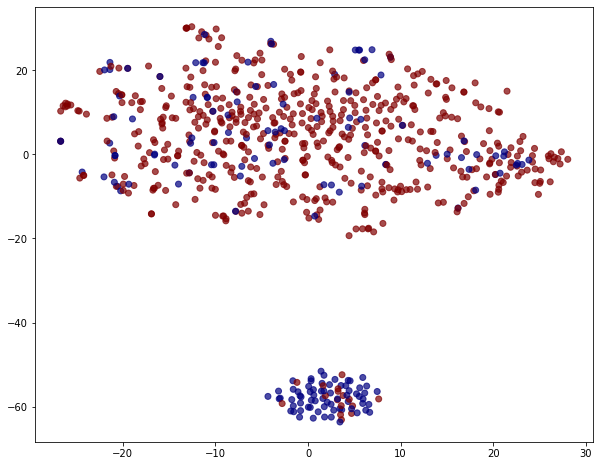

In [60]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    patient_weighted_node_embeddings_2d[:, 0],
    patient_weighted_node_embeddings_2d[:, 1],
    c=patient_node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [61]:
patient_weighted_node_emb_dict = {}
for index, row in patient_square_node_data_no_feature.iterrows():
    if index not in patient_weighted_node_emb_dict:
        patient_weighted_node_emb_dict[index] = weighted_model_patient.wv[index]
    else:
        print(f"index: {index} is already in a dictionary!")

In [62]:
# print(type(patient_weighted_node_emb_dict['aprv']))

In [63]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 42
numpy.random.seed(seed)
tf.random.set_seed(seed)
sg.random.set_seed(seed)

### Load the data

In [64]:
from collections import defaultdict

def create_graph_list(patient_cooc_dict, cooc_odd_scores, node_emb_dict, label):
    
    graphs = []
    labels = []
    
    for key,row in patient_cooc_dict.items():
     
        if row:
            source = []
            target = []
            edge_weight = []
            
            node_feature = []
            node_idx = []
            for cooc in row:
                source.extend([cooc[0], cooc[1]])
                target.extend([cooc[1], cooc[0]])
                edge_weight.extend([cooc_odd_scores[cooc], cooc_odd_scores[cooc]])
        
            node_idx = list(set(source + target))
    
            # Create a dataframe of only nodes
            square_node_data = pd.DataFrame(
                index=node_idx)
            
#             square_node_data['feature'] = [1] * len(node_idx)
        
            # Create a dictionary for each column for a vector
            node_features = defaultdict(list)
            for node in node_idx:
                for i, vec in enumerate(node_emb_dict[node]):
                    node_features['w_' + str(i)].append(vec)
        
            # Add columns to a dataframe
            for k, v in node_features.items():
              
                square_node_data[k] = v

            square_edges = pd.DataFrame({ 
                "source": source, 
                "target": target, 
                "weight":edge_weight
            })
        
            square = StellarGraph({"corner": square_node_data}, {"line": square_edges})
            graphs.append(square)
            labels.append(label)
            
    return graphs, labels

graphs = []
labels = []

# patient_weighted_node_emb_dict
graph_0, label_0 = create_graph_list(patient_cooc_0, new_patient_cooc_odd_scores, patient_weighted_node_emb_dict, -1)
graph_1, label_1 = create_graph_list(patient_cooc_1, new_patient_cooc_odd_scores, patient_weighted_node_emb_dict, 1)

graphs.extend(graph_0)
labels.extend(label_0)
print(f"graphs_0: {len(graphs)}, labels_0: {len(labels)}")
graphs.extend(graph_1)
labels.extend(label_1)
print(f"graphs_1: {len(graph_1)}, labels_1: {len(label_1)}")
print(f"graphs: {len(graphs)}, labels: {len(labels)}")

graphs_0: 191, labels_0: 191
graphs_1: 846, labels_1: 846
graphs: 1037, labels: 1037


In [65]:
# prepare test and train datasets
test_cnt = int(len(graphs)*0.1)/2
print(test_cnt)

pos_start = len(graph_0)
print(pos_start)

test_arr = []
train_arr = []
for i, v in enumerate(graphs):
    # Take first items for neg set
    if i < test_cnt:
        test_arr.append(i)    
    elif i > pos_start and i <= pos_start + test_cnt:
        test_arr.append(i)    
    else:
        train_arr.append(i)

51.5
191


In [66]:
import random
seed = 42
c = list(test_arr)
random.Random(seed).shuffle(c)
test_arr =  c

In [67]:
c = list(train_arr)
random.Random(seed).shuffle(c)
train_arr =  c

In [68]:
train_index = np.array(train_arr)
test_index = np.array(test_arr)

In [69]:
print(len(test_index))
print(test_index)

103
[ 41 218 222   9 207  47   1 212  15 220 198  10  45  33 196  37  50  32
 206  44  30 205   8  21 195 237 229  42 203  26 219 192 235  49 201 214
  48 216 241 199 227  12  36  23  39  40  18 208   5 202   7  34 223  46
   2  51  16  38 200 210  22   6  24 225 233 242 224  19 213  43 228  20
   0 238 197 236 193 231  25 211 232 217 204  29  27 230 240   4 194 215
  11 209 226  13 239  17  28  31  35 234   3  14 221]


In [70]:
print(len(train_index))
print(train_index)

934
[ 846  787  715  547  401  101  814  105  530  342   90  616  350  330
  932  695  729  730  820  912  671  610  938  933  292  464  304  561
  635  280  414  855  744  684  558   70  937  714  805  740  494  779
  392  815  944  803  478  283  528   68  253  747  663  976  698  577
  303  475  421  843  742  136  969  980  987  692  281   80  776  854
  825  986  888  979  852  335  525  596  676  798   76  712   53  559
  301  685  578  553   85  520  526  252  534  390  741  630  847  881
  137  275  775  921  484  844  887  951  919  647  365  488  950  467
  640  531 1006 1025  277  393  405  507  385  636  402  483  794  524
  883  628  708  934 1033  144  162  436  430  296  737  819  181  711
  963  872  352  140  925  822 1018  859   78  407  522  102  830  760
  250  566  487  251 1012  763  501  974  927  461  504  631  826  324
  552  943   81  816  584  458  113 1032  770   57  890  588  334  457
  287   69  946  918  468   65  190   56  382  634  116  961  354  960
  

In [71]:
print(test_arr)

[41, 218, 222, 9, 207, 47, 1, 212, 15, 220, 198, 10, 45, 33, 196, 37, 50, 32, 206, 44, 30, 205, 8, 21, 195, 237, 229, 42, 203, 26, 219, 192, 235, 49, 201, 214, 48, 216, 241, 199, 227, 12, 36, 23, 39, 40, 18, 208, 5, 202, 7, 34, 223, 46, 2, 51, 16, 38, 200, 210, 22, 6, 24, 225, 233, 242, 224, 19, 213, 43, 228, 20, 0, 238, 197, 236, 193, 231, 25, 211, 232, 217, 204, 29, 27, 230, 240, 4, 194, 215, 11, 209, 226, 13, 239, 17, 28, 31, 35, 234, 3, 14, 221]


In [72]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 34, Edges: 538

 Node types:
  corner: [34]
    Features: float32 vector, length 128
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [538]
        Weights: range=[0, 0.788597], mean=0.066801, std=0.188837
        Features: none


In [73]:
print(graphs[100].info())

StellarGraph: Undirected multigraph
 Nodes: 6, Edges: 18

 Node types:
  corner: [6]
    Features: float32 vector, length 128
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [18]
        Weights: range=[0.529817, 0.713582], mean=0.606562, std=0.0576769
        Features: none


In [74]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,1037.0,1037.0
mean,7.5,34.8
std,5.2,53.4
min,2.0,2.0
25%,3.0,6.0
50%,6.0,16.0
75%,10.0,44.0
max,35.0,552.0


In [75]:
graph_labels = pd.Series(labels)

In [76]:
print(graph_labels)

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
1032    1
1033    1
1034    1
1035    1
1036    1
Length: 1037, dtype: int64


In [77]:
graph_labels.value_counts().to_frame()

,0
1,846
-1,191


In [78]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [79]:
print(type(graph_labels))

<class 'pandas.core.frame.DataFrame'>


In [80]:
graph_labels

,1
0,0
1,0
2,0
3,0
4,0
...,...
1032,1
1033,1
1034,1
1035,1


In [81]:
generator = PaddedGraphGenerator(graphs=graphs)

In [82]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

In [83]:
epochs = 200  # maximum number of training epochs
# folds = 10  # the number of folds for k-fold cross validation
# n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [84]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [85]:
# To train in folds
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [86]:
# To train in folds
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, weighted=True, batch_size=batch_size, shuffle=False, seed=42
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, weighted=True, batch_size=batch_size, shuffle=False, seed=42
    )

    return train_gen, test_gen

In [87]:
# # To train in folds
# test_accs = []

# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
#     print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
#     train_gen, test_gen = get_generators(
#         train_index, test_index, graph_labels, batch_size=30
#     )

#     model = create_graph_classification_model(generator)

#     history, acc = train_fold(model, train_gen, test_gen, es, epochs)

#     test_accs.append(acc)

In [88]:
# To train in folds
test_accs = []

# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
for i in range(50):
    print(f"Training and evaluating on fold {i+1}...")
    
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1...
Training and evaluating on fold 2...
Training and evaluating on fold 3...
Training and evaluating on fold 4...
Training and evaluating on fold 5...
Training and evaluating on fold 6...
Training and evaluating on fold 7...
Training and evaluating on fold 8...
Training and evaluating on fold 9...
Training and evaluating on fold 10...
Training and evaluating on fold 11...
Training and evaluating on fold 12...
Training and evaluating on fold 13...
Training and evaluating on fold 14...
Training and evaluating on fold 15...
Training and evaluating on fold 16...
Training and evaluating on fold 17...
Training and evaluating on fold 18...
Training and evaluating on fold 19...
Training and evaluating on fold 20...
Training and evaluating on fold 21...
Training and evaluating on fold 22...
Training and evaluating on fold 23...
Training and evaluating on fold 24...
Training and evaluating on fold 25...
Training and evaluating on fold 26...
Training and evaluati

In [89]:
# 1: Accuracy over all folds mean: 76.0% and std: 4.3%
# 2: Accuracy over all folds mean: 73.9% and std: 6.9%
# 3: Accuracy over all folds mean: 74.4% and std: 6.9%
# 4: Accuracy over all folds mean: 76.4% and std: 2.8%
# 5: Accuracy over all folds mean: 73.4% and std: 5.5%

# -------------- After setting random
# 1: Accuracy over all folds mean: 74.5% and std: 6.6%
# 2: Accuracy over all folds mean: 74.5% and std: 4.7%
# 3: Accuracy over all folds mean: 75.5% and std: 4.6%
# 4: Accuracy over all folds mean: 75.0% and std: 4.5%
# 5: Accuracy over all folds mean: 75.0% and std: 4.7%

print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 75.8% and std: 3.3%


Text(0, 0.5, 'Count')

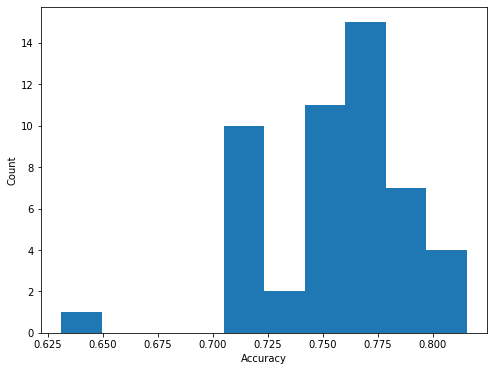

In [90]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [ ]:
# First try
# Accuracy over all folds mean: 77.1% and std: 2.0%

In [89]:
# Second try
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 77.3% and std: 2.6%


Text(0, 0.5, 'Count')

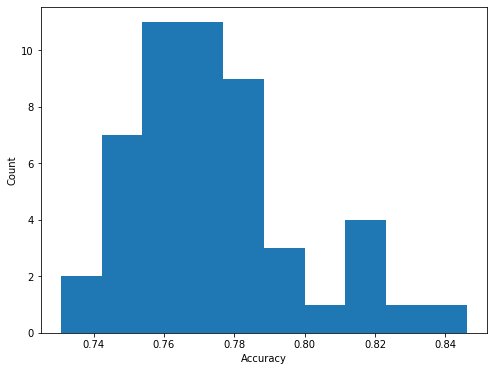

In [90]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [ ]:
# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
#     print(f"\ntrain_index: \n{train_index}\ntest_index: \n{test_index}\n")
#     break
# print(f"train: {len(train_index)}, test: {len(test_index)}")

In [85]:
train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, weighted=True, batch_size=40, shuffle=False, seed=42)
test_gen = generator.flow(
    test_index, targets=graph_labels.iloc[test_index].values, weighted=True, batch_size=40, shuffle=False, seed=42)

In [86]:
model_weighted = create_graph_classification_model(generator)

history = model_weighted.fit(
        train_gen, epochs=200, validation_data=test_gen, verbose=1, callbacks=[es])

Epoch 1/200
18/18 [==============================] - 1s 65ms/step - loss: 0.4357 - acc: 0.8561 - val_loss: 1.0024 - val_acc: 0.5000
Epoch 2/200
18/18 [==============================] - 1s 43ms/step - loss: 0.3849 - acc: 0.8505 - val_loss: 0.8525 - val_acc: 0.5000
Epoch 3/200
18/18 [==============================] - 1s 29ms/step - loss: 0.3468 - acc: 0.8505 - val_loss: 0.6412 - val_acc: 0.5000
Epoch 4/200
18/18 [==============================] - 1s 41ms/step - loss: 0.3245 - acc: 0.8505 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 5/200
18/18 [==============================] - 1s 46ms/step - loss: 0.3225 - acc: 0.8674 - val_loss: 1.0016 - val_acc: 0.5000
Epoch 6/200
18/18 [==============================] - 1s 52ms/step - loss: 0.3271 - acc: 0.8660 - val_loss: 0.8193 - val_acc: 0.5256
Epoch 7/200
18/18 [==============================] - 1s 45ms/step - loss: 0.2875 - acc: 0.8858 - val_loss: 0.6751 - val_acc: 0.6410
Epoch 8/200
18/18 [==============================] - 1s 43ms/step - loss: 0.

In [87]:
# calculate performance on the test data and return along with history
# Node features 128 node2vec, edge features all 1
test_metrics = model_weighted.evaluate(test_gen, verbose=1)
test_acc = test_metrics[model_weighted.metrics_names.index("acc")]

2/2 [==============================] - 0s 22ms/step - loss: 0.4220 - acc: 0.7436


In [88]:
print(test_metrics)
#test loss, test acc: [0.4488869309425354, 0.7692307829856873]
# 2nd time:[0.42735838890075684, 0.7820512652397156]
# 3 : [0.446189284324646, 0.7820512652397156]
print(test_acc)

[0.42195096611976624, 0.7435897588729858]
0.7435897588729858


In [ ]:
print("Generate predictions for samples")
predictions = model_weighted.predict(test_gen, verbose=0)
print("predictions shape:", predictions.shape)
# predictions shape: (79, 1)
print(predictions)

In [ ]:
print(test_gen.targets)